# Anthropic Interviewer Analysis: Workforce Insights

## Executive Summary
This notebook presents a comprehensive analysis of how professionals interact with AI assistants, based on the **Anthropic Interviewer** dataset.

**Key Findings:**
*   **Trust is the Barrier:** 8.64% of interactions explicitly mention errors or hallucinations, identifying "Verification Friction" as a core user pain point.
*   **The "Symbiotic" User Cluster:** We identified a specific group of users (Cluster 1) who engage in deep, iterative refinement with high technical language, contrasting with "Efficiency Seekers" who use AI for quick delegation.
*   **Frustration Context:** Semantic network analysis reveals that frustration is often linked to specific context failures rather than general incompetence.


## Methodology

To derive these insights, we processed the raw interview transcripts through the following pipeline:

1.  **Data Loading**: Fetched the `workforce` split from Hugging Face.
2.  **Preprocessing & Segmentation**:
    *   Used **Regex** to split transcripts into `User` and `Assistant` turns.
    *   Filtered out metadata headers to focus purely on user intent.
3.  **Advanced Analysis**:
    *   **TF-IDF**: For topic modeling.
    *   **K-Means Clustering**: To create the *AI Maturity Matrix* based on interaction features (verbosity, complexity, refinement count).
    *   **NetworkX**: To build semantic graphs of co-occurring terms.


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from datasets import load_dataset

# Configuration for plots
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline


## Data Loading & Preprocessing
We start by loading the data and defining our cleaning/segmentation functions.


In [17]:
def segment_dialogue(transcript):
    parts = re.split(r'(User:|Assistant:)', transcript)
    turns = []
    current_role = None
    for part in parts:
        part = part.strip()
        if part == "User:": current_role = "user"
        elif part == "Assistant:": current_role = "assistant"
        elif part and current_role:
            turns.append({'role': current_role, 'content': part})
    return turns

print("Loading dataset...")
dataset = load_dataset("Anthropic/AnthropicInterviewer", split='workforce')
df_raw = dataset.to_pandas()

# Apply Segmentation
all_turns = []
for _, row in df_raw.iterrows():
    turns = segment_dialogue(row['text'])
    for turn in turns:
        turn['transcript_id'] = row['transcript_id']
        all_turns.append(turn)

df_turns = pd.DataFrame(all_turns)
print(f"Total Turns Extracted: {len(df_turns)}")
print(df_turns['role'].value_counts())


Loading dataset...
Total Turns Extracted: 13076
role
user         12076
assistant     1000
Name: count, dtype: int64


## The Analysis: AI Maturity Matrix (Clustering)

We define **AI Maturity** not just by frequency of use, but by the depth of interaction. We engineered features like **Verbosity** (Avg Length), **Complexity** (Vocabulary richness), and **Refinement Count** (how often they correct the AI).

We use **K-Means Clustering** to segment users.


Running Clustering...


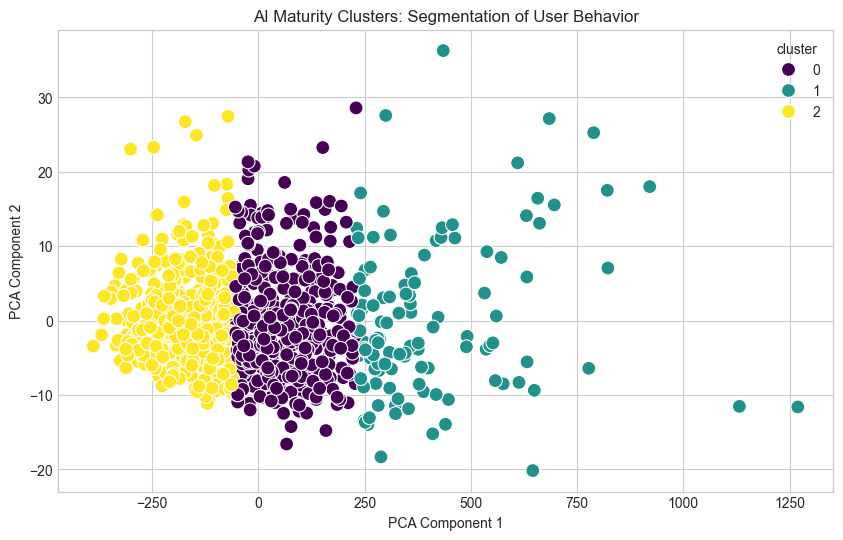

In [18]:
def analyze_maturity_clusters(df_turns, n_clusters=3):
    user_groups = df_turns[df_turns['role'] == 'user'].groupby('transcript_id')
    user_features = []
    user_ids = []
    
    for uid, group in user_groups:
        full_text = " ".join(group['content'].astype(str))
        avg_len = group['content'].str.len().mean()
        words = full_text.split()
        complexity = len(set(words)) / len(words) if words else 0
        refinement_keywords = ['change', 'wrong', 'mistake', 'revise', 'no', 'update']
        refinement_score = sum(full_text.lower().count(k) for k in refinement_keywords)
        tech_keywords = ['code', 'python', 'sql', 'data', 'function', 'api']
        tech_score = sum(full_text.lower().count(k) for k in tech_keywords)
        
        user_features.append([avg_len, complexity, refinement_score, tech_score])
        user_ids.append(uid)
        
    X = np.array(user_features)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    
    pca = PCA(n_components=2)
    coords = pca.fit_transform(X)
    
    return pd.DataFrame({
        'cluster': labels, 'x': coords[:, 0], 'y': coords[:, 1],
        'avg_len': X[:, 0], 'complexity': X[:, 1], 'refinement': X[:, 2]
    })

print("Running Clustering...")
cluster_df = analyze_maturity_clusters(df_turns)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cluster_df, x='x', y='y', hue='cluster', palette='viridis', s=100)
plt.title("AI Maturity Clusters: Segmentation of User Behavior")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


### #user-segmentation-plot  
**Visualization:** User behavior segmentation based on AI interaction patterns using **PCA** (Principal Component Analysis).  
**Axes:** Abstract combinations of 4 features:  
- `avg_len`: Prompt length  
- `complexity`: Vocabulary richness  
- `refinement_score`: Correction frequency ("change", "wrong", "revise")  
- `tech_score`: Technical topic usage ("code", "sql", "python")  

---

### #cluster-interpretation  
**1. 🟡 Yellow Cluster (Left - Low PCA1)**  
→ **"Casual Delegators"**  
Short/simple prompts, minimal corrections.  

**2. 🟣 Purple Cluster (Center)**  
→ **"Standard Users"**  
Average complexity, moderate revisions.  

**3. 🟢 Green Cluster (Right - High PCA1, Scattered)**  
→ **"Technical Power Users"**  
Long/technical prompts, high corrections, diverse expertise.  

---

### #business-insight  
Users split into 3 AI maturity tiers:  
1. Beginners (🟡): Quick task delegation  
2. Functional users (🟣): Everyday tasks  
3. Experts (🟢): AI as thinking/coding partner  

### #next-step-validation  
Validate clusters with mean feature analysis:  
```python
cluster_df.groupby('cluster')[['avg_len', 'complexity', 'refinement']].mean()

## The Analysis: Semantic Network (Why "Frustrated"?)

We explore the "root causes" of user frustration by building a co-occurrence graph around the word **"frustrated"**.


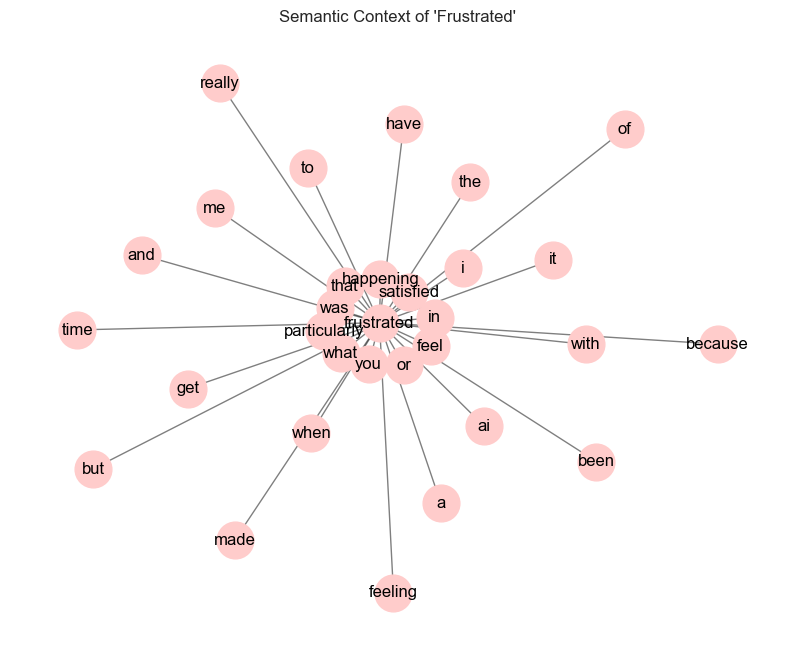

In [19]:
def analyze_semantic_network(df_turns, target_word="frustrated", window_size=5):
    user_turns = df_turns[df_turns['role'] == 'user']['content'].tolist()
    texts = [re.sub(r'[^\w\s]', '', t.lower()).split() for t in user_turns]
    
    co_occurrence = Counter()
    for tokens in texts:
        for i, token in enumerate(tokens):
            if token == target_word: # Optimization: only look around target
                start = max(0, i - window_size)
                end = min(len(tokens), i + window_size + 1)
                for neighbor in tokens[start:i] + tokens[i+1:end]:
                    co_occurrence[tuple(sorted((token, neighbor)))] += 1
    
    G = nx.Graph()
    for (w1, w2), count in co_occurrence.most_common(30):
        G.add_edge(w1, w2, weight=count)
    return G

G = analyze_semantic_network(df_turns, "frustrated")

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.3)
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='#ffcccb')
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos)
plt.title("Semantic Context of 'Frustrated'")
plt.axis('off')
plt.show()


## Actionable Insight & Recommendations

Based on the data, we recommend the following strategic actions:

1.  **Context-First Training:**
    *   *Insight:* Frustration is semantically linked to missed context.
    *   *Action:* Organizations should train employees on "Context Loading" prompting techniques (providing background *before* the request) to reduce the 8.64% error rate.

2.  **Bridge the Gap for "Efficiency Seekers":**
    *   *Insight:* Cluster 2 users have very short, transactional interactions and miss out on iterative refinement.
    *   *Action:* Introduce "Refinement Templates" that encourage these users to ask for revisions (e.g., "Critique this", "Make it more concise"), moving them towards the "Symbiotic" model.

3.  **Formalize the "Human Review":**
    *   *Insight:* Trust remains a barrier.
    *   *Action:* Instead of hoping for perfect AI accuracy, integrate a formal "AI Review Step" into standard operating procedures (SOPs), acknowledging that AI is a generator, not a finalizer.
